<a href="https://colab.research.google.com/github/alwaysneedhelp/Football-AI/blob/main/Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import kagglehub
import os
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap

In [ ]:
rf = xgb.XGBClassifier(reg_lambda=1)

**FUNCTION TO LOAD FILES FROM KAGGLEHUB**

In [ ]:
def load_file(link, name):
  path = kagglehub.dataset_download(link)
  path = os.path.join(path, f'{name}.csv')
  return path

**MAKE IT EASIER TO WORK WITH PREDICTOR LIST**

In [ ]:
predictors = []
def add(*args):
  global predictors
  for each in args:
    if each not in predictors:
      predictors.append(each)
      log_info(f'Added:{each}')
def rid(*args):
  global predictors
  for a in args:
    if a in predictors:
      predictors.remove(a)
      log_info(f'Deleted:{a}')

In [ ]:
matches = pd.read_csv(load_file('martj42/international-football-results-from-1872-to-2017', 'results'))

**PREPARING DATA FOR AI**

In [ ]:
matches['date'] = pd.to_datetime(matches['date'])

In [ ]:
matches['opp_code'] = matches['away_team'].astype('category').cat.codes

In [ ]:
matches['day_code'] = matches['date'].dt.dayofweek
matches['goal_diff'] = matches['home_score'] - matches['away_score']

In [ ]:
matches['result'] = (matches['home_score'] > matches['away_score']).astype('int')

In [ ]:
matches['is_home'] = matches['neutral'].apply(lambda x: not x).astype(bool)
matches['tournament_id'] = matches['tournament'].astype('category').cat.codes
matches['city_id'] = matches['city'].astype('category').cat.codes
matches['country_id'] = matches['country'].astype('category').cat.codes

**CALCULATE ELO**

In [ ]:
def calculate_elo(my_code, opp_code, rating_a, rating_b, res, weight=1, add_on=0):
  K = 100
  expected_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
  new_ratinga = rating_a + weight * K*(res-expected_a)

  expected_b = 1 / (1 + 10 ** ((rating_a - rating_b) / 400))
  new_ratingb = rating_b + weight * K*(res-expected_b)

  elo_ratings[my_code] = new_ratinga+add_on
  elo_ratings[opp_code] = new_ratingb+add_on

  return new_ratinga, new_ratingb

**ADDING CODE FOR ELO TO BE CALCULATED PROPERLY FOR EACH COUNTRY**

In [ ]:
matches['elo'], matches['opp_elo'] = 2000, 2000
matches['my_code'] = matches['home_team'].astype('category').cat.codes
matches['opp_code'] = matches['away_team'].astype('category').cat.codes
all_codes = pd.concat([matches['my_code'], matches['opp_code']]).unique()
elo_ratings = dict(zip(all_codes, [2000] * len(all_codes)))

In [ ]:
matches[['elo', 'opp_elo']] = matches.apply(
    lambda row:calculate_elo(
        row['my_code'],
        row['opp_code'],
        elo_ratings[row['my_code']],
        elo_ratings[row['opp_code']],
        row['result'],
        #tournament_weights[row['tournament']],
    ),
    axis=1,
    result_type='expand'
)

STORE INFO TO COMPARE LATER

In [ ]:
import logging

# Create and configure logger
logging.basicConfig(filename="accuracies.log",
                    format='%(asctime)s %(message)s',
                    filemode='a',
                    force=True # Reset previous settings
                    )

# Creating an object
logger = logging.getLogger()

# Setting the threshold of logger to INFO
logger.setLevel(logging.INFO)

In [ ]:
def log_info(*args):
  for arg in args:
    logger.info(arg)
    logger.info('--------------------------------------------------------------')
  logger.info('---------------------------------------------------------------------------------')

**FUNC TO ALWAYS CHECK IF CHANGES DONE HAD ANY RESULT ON ACC OR PRECISION**

In [ ]:
def check_predictions(matches, predictors):
  X_train, X_test, y_train, y_test = train_test_split(
      matches[predictors].values,
      matches['result'].values,
      test_size=0.2,
      random_state=42
  )
  dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=predictors)
  rf.fit(X_train, y_train)
  preds = rf.predict(X_test)
  combined = pd.DataFrame(dict(actual=y_test, predicted=preds))
  acc = f'Accurasy score: {accuracy_score(y_test, preds)}'
  prec = f'Precision score: {precision_score(y_test, preds)}'
  recall = f'Recall score: {recall_score(y_test, preds)}'
  f1 = f'F1 score: {f1_score(y_test, preds)}'
  print(acc)
  print(prec)
  print(recall)
  print(f1)
  log_info(acc, prec, recall, f1)

In [ ]:
fifa_ranking = pd.read_csv(load_file('cashncarry/fifaworldranking', 'fifa_ranking-2024-06-20'))

100%|██████████| 1.69M/1.69M [00:00<00:00, 39.6MB/s]

Extracting files...


**PREPARING FIFA RANKING TABLE TO MERGE WITH MY ELO SYSTEM**

In [ ]:
fifa_ranking = fifa_ranking.rename(columns={
    'country_full': 'home_team',
    'rank': 'home_fifa_rank',
    'rank_date': 'date'
})
matches['date'] = pd.to_datetime(matches['date'])
fifa_ranking['date'] = pd.to_datetime(fifa_ranking['date'])
add('my_code', 'elo', 'opp_elo', 'opp_code', 'day_code', 'neutral', 'tournament_id', 'city_id', 'country_id')
check_predictions(matches, predictors)

Accurasy score: 0.7118855009334163
Precision score: 0.7058442958809575
Recall score: 0.6983144868786004
F1 score: 0.702059202059202


In [ ]:
fifa_ranking_away = fifa_ranking.rename(columns={
    'home_team': 'away_team',
    'home_fifa_rank': 'away_fifa_rank',
    'previous_points': 'away_previous'
})
rankings_merged = pd.merge_asof(
    matches.sort_values('date'),
    fifa_ranking.sort_values('date'),
    on='date',
    by='home_team',
    direction='backward')
rankings_merged = pd.merge_asof(
    rankings_merged.sort_values('date'),
    fifa_ranking_away.sort_values('date'),
    on='date',
    by='away_team',
    direction='backward'
)
rankings_merged['fifa_rank_diff'] = rankings_merged['home_fifa_rank'] - rankings_merged['away_fifa_rank']
rankings_merged['previous_diff'] = rankings_merged['previous_points'] - rankings_merged['away_previous']

In [ ]:
add('home_fifa_rank', 'previous_points',)
check_predictions(rankings_merged, predictors)

Accurasy score: 0.7310723916199958
Precision score: 0.7286670987254267
Recall score: 0.7161358811040339
F1 score: 0.722347146375415


In [ ]:
more_data = pd.read_csv(load_file('piterfm/fifa-football-world-cup', 'matches_1930_2022'))

100%|██████████| 180k/180k [00:00<00:00, 29.8MB/s]

Extracting files...


In [ ]:
more_data = more_data.rename(columns={
    'Date': 'date'
})
more_data['date'] = pd.to_datetime(more_data['date'])

rankings_merged = pd.merge(
    more_data.sort_values('date'),
    rankings_merged.sort_values('date'),
    on=['date', 'home_team', 'away_team'],
)

In [ ]:
def top_teams(N, matches):
  top_teams = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)[:N]
  for id, elo in top_teams:
    name = matches[matches['my_code']==id]['home_team']
    print(f'{name}:{elo}')

In [ ]:
rankings_merged['home_rolling_diff'] = (
    rankings_merged.groupby('home_team')['home_score_x']
    .rolling(window=5, min_periods=1)
    .sum()
    .shift(1)
    .reset_index(level=0, drop=True)
)
rankings_merged['away_rolling_diff'] = (
    rankings_merged.groupby('away_team')['away_score_x']
    .rolling(window=5, min_periods=1)
    .sum()
    .shift(1)
    .reset_index(level=0, drop=True)
)

In [ ]:
 add('home_rolling_diff',
    'away_rolling_diff',
)
check_predictions(rankings_merged, predictors)

Accurasy score: 0.7956204379562044
Precision score: 0.8076923076923077
Recall score: 0.8289473684210527
F1 score: 0.8181818181818182


In [ ]:
rankings_merged['away_days_since_last_game'] = rankings_merged.groupby('away_team')['date'].diff().dt.days
add('away_days_since_last_game')
check_predictions(rankings_merged, predictors)

Accurasy score: 0.7956204379562044
Precision score: 0.8076923076923077
Recall score: 0.8289473684210527
F1 score: 0.8181818181818182


In [ ]:
rankings_merged['rolling_form'] = (
    rankings_merged.groupby('home_team')['home_xg']
    .rolling(window=5, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)
rankings_merged['rolling_form_away'] = (
    rankings_merged.groupby('away_team')['away_xg']
    .rolling(window=5, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

In [ ]:
predictors

['my_code',
 'elo',
 'opp_elo',
 'opp_code',
 'day_code',
 'neutral',
 'tournament_id',
 'city_id',
 'country_id',
 'home_fifa_rank',
 'previous_points',
 'home_rolling_diff',
 'away_rolling_diff',
 'away_days_since_last_game']

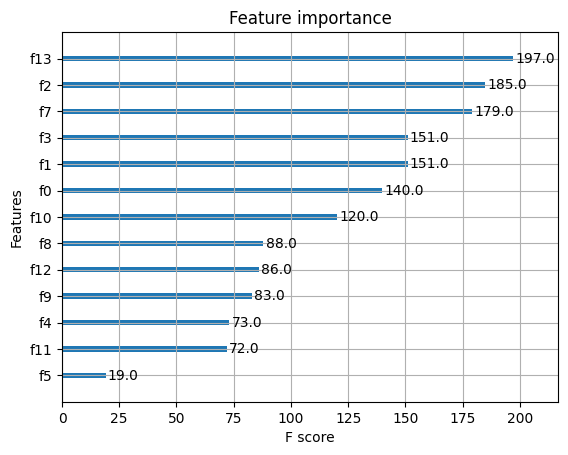

feauture 0 is my_code
feauture 1 is elo
feauture 2 is opp_elo
feauture 3 is opp_code
feauture 4 is day_code
feauture 5 is neutral
feauture 6 is tournament_id
feauture 7 is city_id
feauture 8 is country_id
feauture 9 is home_fifa_rank
feauture 10 is previous_points
feauture 11 is home_rolling_diff
feauture 12 is away_rolling_diff
feauture 13 is away_days_since_last_game


In [ ]:
plot_importance(rf, importance_type='weight')
plt.show()
for i in range(len(predictors)):
  print(f'feauture {i} is {predictors[i]}')